In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot

# Set figure style
import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])



In [4]:
#Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Location = r"//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Thermal_actuation/Experimental/Fluidic/Pressure_flow_plastic_bottle"
Foldernames = ["/Data"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

print(data[0][-1].head)

Loading... Folder 1 of 1, Sample 1 of 8
Loading... Folder 1 of 1, Sample 2 of 8
Loading... Folder 1 of 1, Sample 3 of 8
Loading... Folder 1 of 1, Sample 4 of 8
Loading... Folder 1 of 1, Sample 5 of 8
Loading... Folder 1 of 1, Sample 6 of 8
Loading... Folder 1 of 1, Sample 7 of 8
Loading... Folder 1 of 1, Sample 8 of 8
<bound method NDFrame.head of        presFesto-0  AWM20-12  SSCDP05-3    Time
0         0.000387 -0.002912 -15.255849   0.001
1         0.000155 -0.001955 -14.905454   0.002
2        -0.000019 -0.001086 -14.891623   0.003
3        -0.000140 -0.000304 -15.169332   0.004
4        -0.000213  0.000392 -15.693559   0.005
...            ...       ...        ...     ...
19595     0.072877  0.066065   3.291364  19.596
19596     0.072835  0.066664   0.243335  19.597
19597     0.072798  0.067566  -4.106382  19.598
19598     0.072769  0.068807  -9.915566  19.599
19599     0.072749  0.070422 -17.341999  19.600

[19600 rows x 4 columns]>


In [52]:
for i in range(len(data[0])):
    cutoff =10
    f=data[1]['Samplerate'][i]
    
    new_zero = data[0][i]['Time'][cutoff*f]
    data[0][i]['Time']=data[0][i]['Time']-new_zero
    data[0][i]=data[0][i].iloc[cutoff*f:]

KeyError: 10000

In [51]:
data[1]

{'Samplerate': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
 'Samplename': ['p10kpa',
  'p30kpa',
  'p50kpa',
  'p80kpa',
  'p100kpa',
  'p2_25kpa',
  'p5kpa',
  'p8kpa'],
 'Offset': [{'presFesto-0': 5.040482444444444,
   'AWM20-12': 1.0205983333333335,
   'SSCDP05-3': 2.5123115555555557},
  {'presFesto-0': 5.0394526666666675,
   'AWM20-12': 1.020833777777778,
   'SSCDP05-3': 2.509509},
  {'presFesto-0': 5.040506777777778,
   'AWM20-12': 1.0207154444444446,
   'SSCDP05-3': 2.5090715555555554},
  {'presFesto-0': 5.039768222222222,
   'AWM20-12': 1.0207822222222223,
   'SSCDP05-3': 2.5083496666666667},
  {'presFesto-0': 5.040312222222223,
   'AWM20-12': 1.020766,
   'SSCDP05-3': 2.510386666666667},
  {'presFesto-0': 5.0387960000000005,
   'AWM20-12': 1.0211664444444446,
   'SSCDP05-3': 2.5086287777777776},
  {'presFesto-0': 5.038554777777778,
   'AWM20-12': 1.020697888888889,
   'SSCDP05-3': 2.5076973333333337},
  {'presFesto-0': 5.038341555555555,
   'AWM20-12': 1.0204916666666666,

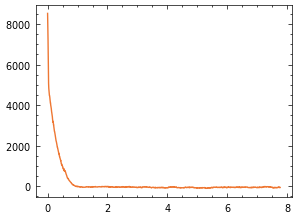

In [33]:
treshold=70
difference=np.diff(data[0][0]['SSCDP05-3'])

indices = np.where(difference < -treshold)

sharp_decrease= data[0][0]['SSCDP05-3'][indices[0]]
plt.plot(data[0][0]['Time'][:-indices[0][0]],data[0][0]['SSCDP05-3'][indices[0][0]:])

71
292
1540
12919
2030
115
90
100


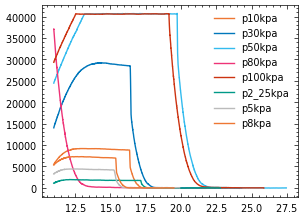

In [49]:
data[0][0]['SSCDP05-3']
for i in range(len(data[0])):
    treshold=100
    difference=np.diff(data[0][i]['SSCDP05-3'])
    indices = np.argmax(difference)
    print(indices)

    plt.plot(data[0][i]['Time'][:-indices],data[0][i]['SSCDP05-3'][indices:],label=data[1]['Samplename'][i])
    #plt.plot(data[0][i]['Time'],data[0][i]['SSCDP05-3'],label = data[1]['Samplename'][i])

plt.legend()

In [41]:
np.max(difference)

12.17725972540029